<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Fruits_unsupervised_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/Fruits.zip -d /content/

Archive:  /content/Fruits.zip
replace /content/Fruits/1.jfif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Fruits/1.jfif  
  inflating: /content/Fruits/10.jfif  
  inflating: /content/Fruits/100.jfif  
  inflating: /content/Fruits/101.jfif  
  inflating: /content/Fruits/102.jfif  
  inflating: /content/Fruits/103.jfif  
  inflating: /content/Fruits/104.jfif  
  inflating: /content/Fruits/105.jfif  
  inflating: /content/Fruits/106.jfif  
  inflating: /content/Fruits/107.jfif  
  inflating: /content/Fruits/108.jfif  
  inflating: /content/Fruits/109.jfif  
  inflating: /content/Fruits/11.jfif  
  inflating: /content/Fruits/110.jfif  
  inflating: /content/Fruits/111.jfif  
  inflating: /content/Fruits/112.jfif  
  inflating: /content/Fruits/113.jfif  
  inflating: /content/Fruits/114.jfif  
  inflating: /content/Fruits/115.jfif  
  inflating: /content/Fruits/116.jfif  
  inflating: /content/Fruits/117.jfif  
  inflating: /content/Fruits/118.jfif  
  inflating: /content/

In [ ]:
import glob

In [ ]:
Data_path = "/content/Fruits/"

In [ ]:
filelist = glob.glob(Data_path+'/*.jfif')

In [ ]:
filelist[2]

'/content/Fruits/2.jfif'

In [ ]:
len(filelist)

126

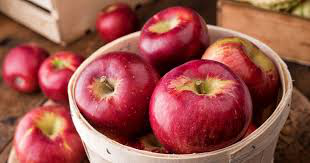

In [ ]:
from PIL import Image

Image.open(filelist[125])

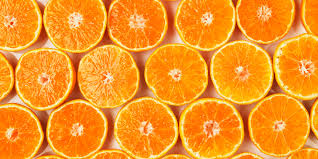

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(filelist[9])

img.shape
cv2_imshow(img)


Lets Resize all images to same size

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
  def __init__(self,path,new_size = 225):
    self.filelist = glob.glob(path+'/*.jfif')
    self.new_size = new_size

  def __len__(self):
    return len(self.filelist)

  def __getitem__(self, idx):
    img = cv2.imread(self.filelist[idx])
    img = cv2.resize(img,(self.new_size,self.new_size))
    img = transforms.ToTensor()(img).reshape(self.new_size*self.new_size*3)
    return img

In [ ]:
Data = CustomDataset(Data_path)
Data[1].shape

torch.Size([151875])

**Lets write the first Auto encoder **

In [ ]:
latent_dim = 10
input_size = 151875

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
        #self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, latent_dim)
       
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        #out = self.relu(self.fc2(out))
        
        return self.fc3(out)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        #self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, input_size)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        #out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        
        z = self.enc(x.view(-1, input_size))
        
        out = self.dec(z)
        
        return out


In [ ]:
train_loader = DataLoader(Data,batch_size=1)

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import clear_output
net = AutoEncoder()
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

if torch.cuda.is_available():
    net.cuda()

net.train()

for epoch in tqdm(range(10)) :
    print(epoch)
    for x in tqdm( train_loader):
        optimizer.zero_grad()
        
        
        if torch.cuda.is_available():
            x = x.cuda()
        prediction = net(x)
        
        
        mse_loss = loss_func(prediction, x.view(-1,input_size)) # <-- note that i'm using the input as the target
         
        
        mse_loss.backward()
        optimizer.step()
        
    clear_output(wait=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


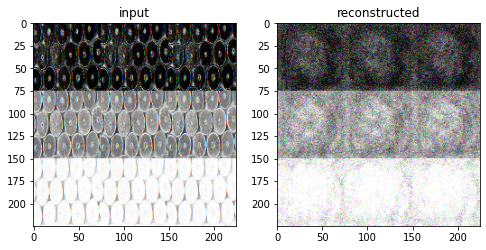

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(8,4))

net.cpu()
net.eval()

img = Data[9]

decoded = net(img).data.numpy().reshape(225,225,3)

ax[0].imshow( img.data.numpy().reshape(225,225,3))
ax[1].imshow( decoded)

ax[0].set_title('input')
ax[1].set_title('reconstructed')

plt.show()